# Test whether spike trajectories in fluctuation-driven sequence generation are chaotic

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd
from disp import set_plot
from ntwk import SoftmaxNtwk

In [2]:
D = 16

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_0 = 100
t_max = 100

In [3]:
N = 2000

In [4]:
A = np.arange(0, 2*np.pi, 2*np.pi/D)

# Variance-driven sequence network (starting from variance self-coupled network)

In [5]:
MU_J_SELF = 0
MU_J_CROSS = 0
MU_J_SEQ = 0

SGM_J_SELF = 10
SGM_J_CROSS = 1
SGM_J_SEQ = 10

sys.stdout.write('\n>')

MU_J = np.nan*np.zeros((D, D))
SGM_J = np.nan*np.zeros((D, D))

MU_J[mself] = MU_J_SELF
MU_J[~mself] = MU_J_CROSS
MU_J[mseq] = MU_J_SEQ

SGM_J[mself] = SGM_J_SELF
SGM_J[~mself] = SGM_J_CROSS
SGM_J[mseq] = SGM_J_SEQ

J = np.nan*np.zeros((D, D, N, N))

for d_to in range(D):
    for d_from in range(D):
        J[d_to, d_from, :, :] = SGM_J[d_to, d_from]*np.sqrt(D/N)*np.random.randn(N, N) + MU_J[d_to, d_from]*D/N

ntwk = SoftmaxNtwk(J)


>

In [6]:
# NTR = 1
NTR = 10

y_refs_y_ptbs_all = []

for ctr in range(NTR):
    
    # initial run
    sys.stdout.write('>')
    x_0 = np.random.randn(N, D)
    x_0[:, :10] *= 5
    g = np.inf
    
    t, xs_0, ys_0 = ntwk.run(g=g, t_max=t_0, x_0=x_0, progress=5)

    ths_0 = ys_0.mean(axis=1)

    # reference run
    sys.stdout.write('>')
    
    y_0 = ys_0[-1, :, :].copy()

    t, _, ys_ref = ntwk.run(g=g, t_max=t_max, y_0=y_0, progress=5)

    # perturbed run
    sys.stdout.write('>')
    
    y_0_ptb = y_0.copy()
    
    # shift a random row by 1 (w periodic bdry)
    irow = np.random.randint(0, N)
    
    y_0_ptb[irow, :] = np.roll(y_0_ptb[irow, :], 1)
    
    t, _, ys_ptb = ntwk.run(g=g, t_max=t_max, y_0=y_0_ptb, progress=5)
    
    y_refs_y_ptbs_all.append((ys_ref, ys_ptb))
    print('')

>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................
>...................>...................>...................


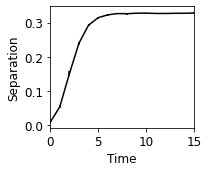

In [14]:
dists_all = []
for ys_ref, ys_ptb in y_refs_y_ptbs_all:
    dists = np.sqrt(np.mean((ys_ref-ys_ptb)**2, axis=(1, 2)))
    dists_all.append(dists)
    
dists_all = np.array(dists_all)

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5), tight_layout=True)
ax.errorbar(t, dists_all.mean(0), yerr=dists_all.std(0), c='k')
    
set_plot(ax, x_lim=(0, 15), x_label='Time', y_label='Separation')

fig.savefig('figs/main/5_seq_chaos.svg')

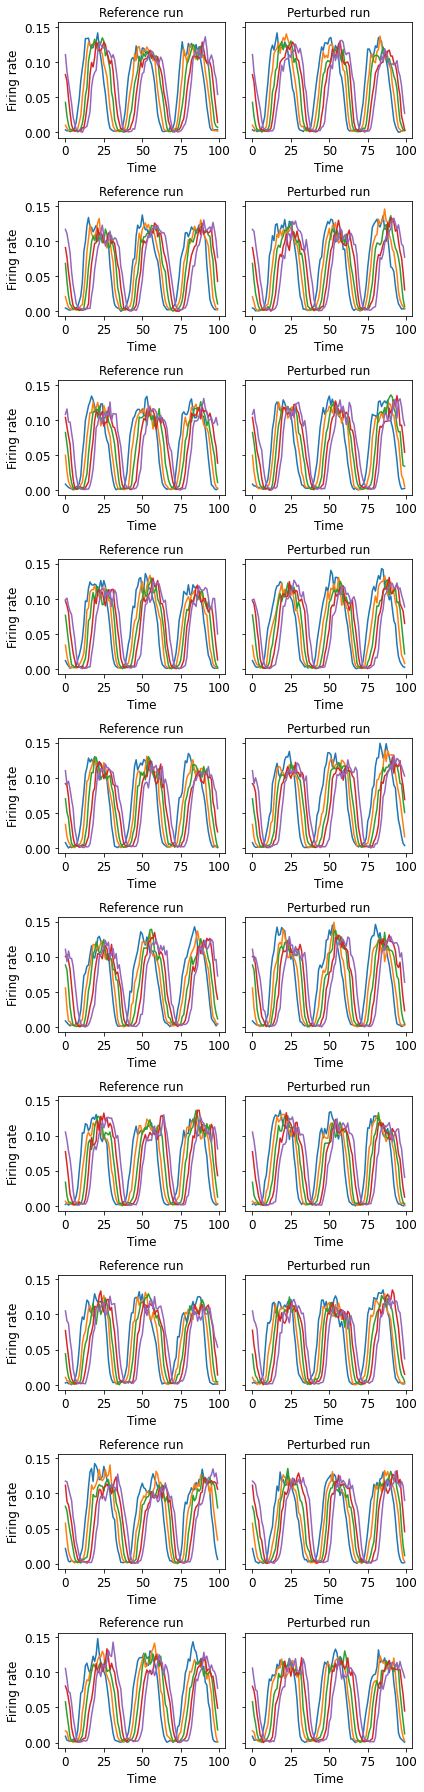

In [13]:
fig, axs = plt.subplots(NTR, 2, figsize=(6, NTR*2.5), tight_layout=True, sharey=True)

for ctr, (ys_ref, ys_ptb) in enumerate(y_refs_y_ptbs_all):
    ths_ref = ys_ref.mean(axis=1)
    ths_ptb = ys_ptb.mean(axis=1)
    
    axs[ctr, 0].plot(ths_ref[:, :5])
    axs[ctr, 0].set_title('Reference run')
    axs[ctr, 0].set_ylabel('Firing rate')
    axs[ctr, 1].plot(ths_ptb[:, :5])
    axs[ctr, 1].set_title('Perturbed run')
    
    for ax in axs[ctr, :]:
        set_plot(ax, x_label='Time')
        
fig.savefig('figs/main/5_seq_chaos_firing_rates.svg')